In [25]:
using JuMP, CPLEX
model = Model(CPLEX.Optimizer)
set_attribute(model, "CPX_PARAM_EPINT", 1e-8)
set_optimizer_attribute(model, "CPX_PARAM_MIPSEARCH", 1)
using Printf
using FileIO
using Plots
using Random

# Function to calculate Euclidean distance
function calculate_distance(x1, y1, x2, y2)
    return sqrt((x1 - x2)^2 + (y1 - y2)^2)
end

# Function to calculate distance matrix
function calculate_distance_matrix(x,y,nc)
    distances = zeros(length(x),length(x))
    for i in 1:length(x)
        for j in 1:length(y)
            if(i==j)
                distances[i,j] = 10000.00
            elseif((i==1 || j==1)&&(length(x)-i<nc || length(y)-j<nc))
                distances[i, j] = 10000.00
            else
                distances[i, j] = (calculate_distance(x[i], y[i], x[j], y[j]))
            end
        end
    end
    
    return distances

end


# Define a structure for the customer data
struct Customer
    cust_no::Int
    xcoord::Int
    ycoord::Int
    demand::Int
    ready_time::Int
    due_date::Int
    service_time::Int
end

function readFile(file_path)
    # Read the file lines
    lines = open(file_path, "r") do file
        readlines(file)
    end

    # Find the index where the customer data starts
    start_index = findfirst(contains.(lines, "CUST NO.")) + 1

    x_coor_customers = []
    x_coor_depot = []
    y_coor_customers = []
    y_coor_depot = []
    demands = []
    n_cust = []
    time_windows = []
    zeta = 0

    # Parse the customer data
    customers = []
    for i in start_index+1:length(lines)
        line = strip(lines[i])
        if !isempty(line)
            fields = split(line)
            # Depot
            if i == start_index + 1
                push!(x_coor_depot, parse(Int, fields[2]))
                push!(y_coor_depot, parse(Int, fields[3]))
                zeta = parse(Int, fields[6])
            else
                # Customers
                customer = Customer(
                    parse(Int, fields[1]),
                    parse(Int, fields[2]),
                    parse(Int, fields[3]),
                    parse(Int, fields[4]),
                    parse(Int, fields[5]),
                    parse(Int, fields[6]),
                    parse(Int, fields[7])
                )
                push!(customers, customer)
            end
        end
    end
    
    # Fill in the attributes
    for customer in customers
        push!(x_coor_customers, customer.xcoord)
        push!(y_coor_customers, customer.ycoord)
        push!(demands, customer.demand)
        push!(n_cust, customer.cust_no)
        push!(time_windows, (customer.ready_time, customer.due_date))
    end
    
    return x_coor_customers, y_coor_customers, x_coor_depot, y_coor_depot, n_cust, demands, time_windows, zeta
    
end

function displayMap()
    default(size=(800, 600))
    gr()
    
    # Create a customers scatter plot
    scatter(x_coor_customers, y_coor_customers,
                   title = "Coordinate Plot",
                   xlabel = "X-axis",
                   ylabel = "Y-axis",
                   legend = false, markersize = 6, markercolor = :pink, 
                   marker=:utriangle, markerstrokecolor = :transparent, 
                   markerstrokewidth=0, label = "Customers")

    # Create a parking scatter plot
    scatter!(x_coor[2:1+np], y_coor[2:1+np], 
            title = "Coordinate Plot",
            xlabel = "X-axis", ylabel = "Y-axis",
            legend = false)
 
    # Add the depot point in a different color
    scatter!([x_coor[1]], [y_coor[1]], 
             markersize = 8, markercolor = :yellow)
   
    # Add the initial parking place in a different color
    for p in P
        if PI[p-1]==1
            scatter!([x_coor[p]], [y_coor[p]], 
                 markersize = 8, markercolor = :lightblue)
        else
            scatter!([x_coor[p]], [y_coor[p]], 
             markersize = 6, markercolor = :white)
        end
    end

    # plot!()     
end

function backTracking(z, colorR, x)
    for k in A2
        if round(value(z[x,k])) == 1
            plot!([x_coor[x], x_coor[k]], [y_coor[x], y_coor[k]], line=:arrow, color = colorR)
            if k in P   return  end
            backTracking(z, colorR, k)           
            colorR = RGBA(rand(),rand(),rand(),1)
        end
    end
end


function randomGenerateParking(x_coor_customers,y_coor_customers)    
    # Define the boundaries of the customer area
    x_min, x_max = minimum(x_coor_customers), maximum(x_coor_customers)
    y_min, y_max = minimum(y_coor_customers), maximum(y_coor_customers)

    # Define the number of divisions (4x4 grid)
    num_divisions = 4
    x_step = (x_max - x_min) / num_divisions
    y_step = (y_max - y_min) / num_divisions

    # Initialize empty arrays to store the parking coordinates
    x_coor_parkings = []
    y_coor_parkings = []

    # Loop over the grid and generate a random point in each sub-area
    for i in 1:num_divisions-1
        for j in 1:num_divisions-1
            # Define the boundaries of the current sub-area
            x_lower = x_min + i * x_step
            x_upper = x_min + (i + 1) * x_step
            y_lower = y_min + j * y_step
            y_upper = y_min + (j + 1) * y_step

            # Generate a random point within the current sub-area
            push!(x_coor_parkings, rand(x_lower:x_upper))
            push!(y_coor_parkings, rand(y_lower:y_upper))
        end
    end
    return x_coor_parkings, y_coor_parkings
end

function fixedGenerateParking(x_coor_customers,y_coor_customers)    
    # Define the boundaries of the customer area
    x_min, x_max = minimum(x_coor_customers), maximum(x_coor_customers)
    y_min, y_max = minimum(y_coor_customers), maximum(y_coor_customers)

    # Define the number of divisions (4x4 grid)
    num_divisions = 5
    x_step = (x_max - x_min) / num_divisions
    y_step = (y_max - y_min) / num_divisions

    # Initialize empty arrays to store the parking coordinates
    x_coor_parkings = []
    y_coor_parkings = []

    for j in 1:num_divisions-1
        for i in 1:num_divisions-1
            push!(x_coor_parkings, x_min + i * x_step)
            push!(y_coor_parkings, y_min + j * y_step)
        end
    end

    return x_coor_parkings, y_coor_parkings
end


fixedGenerateParking (generic function with 1 method)

Any[15.0, 30.0, 45.0, 60.0, 15.0, 30.0, 45.0, 60.0, 15.0, 30.0, 45.0, 60.0, 15.0, 30.0, 45.0, 60.0]
16
Any[16.0, 16.0, 16.0, 16.0, 27.0, 27.0, 27.0, 27.0, 38.0, 38.0, 38.0, 38.0, 49.0, 49.0, 49.0, 49.0]
 
20
C101-20
../Data/Result/C101-20/C101-20-data.png


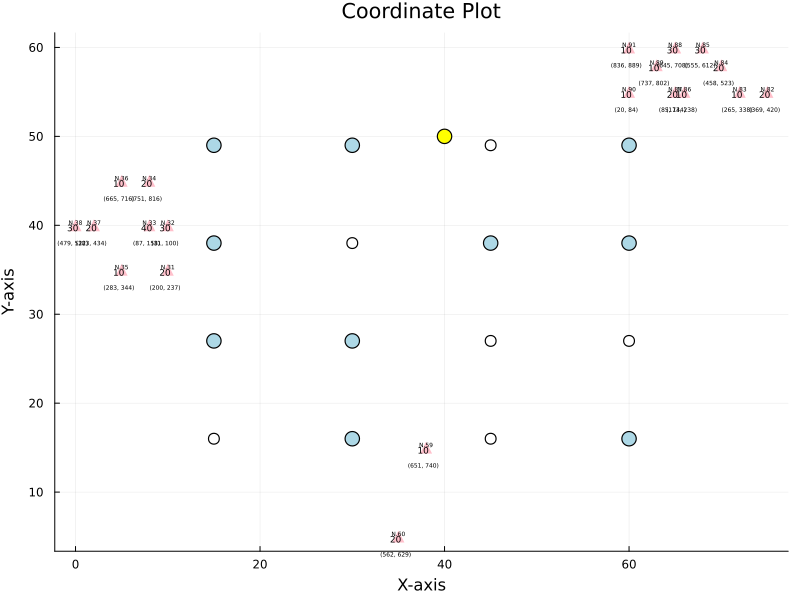

In [40]:
#===========SET==============================================================#
filePath = "../Data/Demo/C101-20.txt"
x_coor_customers, y_coor_customers, x_coor_depot, y_coor_depot, 
    n_cust, demands, time_windows, zeta = readFile( filePath )
# Number of customers
nc = length(x_coor_customers)
# Coordinate (Parking node)
x_coor_parkings, y_coor_parkings = fixedGenerateParking(x_coor_customers, y_coor_customers)
# println(x_coor_parkings)
# println(length(x_coor_parkings))
# println(y_coor_parkings)
# Number of parking places
np = length(x_coor_parkings)
P = 2 : np+1 #Set of parking place
C = np+2 : np+nc+1 #Set of customers
A1 = 1 : 1+np #Set of FE arcs
A2 = 2 : 1+np+nc #Set of SE arcs
V1 = 1:1 #Set of FEV
V2 = 1:10 #Set of SEV
N = 1:np+nc+1 #Set of nodes

#===========PARAMETER========================================================#
Q0 = 10000 #Capacity of FEV
Q1 = 6000 #Capacity of MM
Q2 = 200 #Capacity of SEV
M = 10000
PI = vcat(ones(Int,10),zeros(Int,6))#Initial parking indicator
shuffle!(PI)
PI = [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]
eta1 = 2
eta2 = 1
x_coor = vcat(x_coor_depot, x_coor_parkings, x_coor_customers)
y_coor = vcat(y_coor_depot, y_coor_parkings, y_coor_customers)

# Disatance matrix
distances = calculate_distance_matrix(x_coor,y_coor,nc)
Vitesse1 = 2
Vitesse2 = 1
println(" ")
TT1 = (distances / Vitesse1)
TT2 = (distances / Vitesse2)

println(nc)
displayMap()

demand_labels = [string(demands[i-1-np]) for i in C]
for i in C
    annotate!(x_coor[i]-0.3, y_coor[i]-0.3, text(demand_labels[i-1-np], :center, 6)) 
end 

tw_labels = [string(time_windows[i-1-np]) for i in C]
for i in C
    annotate!(x_coor[i]-0.3, y_coor[i]-2, text(tw_labels[i-1-np], :center, 4)) 
end 

node_labels = [string("N.", n_cust[i]) for i in 1:length(C)]
for i in C
    annotate!(x_coor[i], y_coor[i]+0.3, text(node_labels[i-1-np], :center, 4))
end


fileName = splitext(basename(filePath))[1]
println(fileName)
save_dir = "../Data/Result/"
save_path = joinpath(save_dir, fileName,fileName * "-data.png")
println(save_path)

# Check if directory exists, if not, create it
dir_path = dirname(save_path)
if !isdir(dir_path)
    mkdir(dir_path)
end

# savefig(save_path)
plot!()


In [3]:
model=Model(CPLEX.Optimizer)

# Decision variable
@variable(model, x[A1,A1], Bin)#Arc(x,y) traversed by FEV
@variable(model, y[A1,A1], Bin)#Arc(x,y) traversed by MM
for i in 1:np+1
    @constraint(model, x[i, i] == 0)
    @constraint(model, y[i, i] == 0)
end

@variable(model, t[A2]>=0, Int) #Arrival time

@variable(model, w[P]>=0, Int) #Amount of freight transported from the depot to parking node

@variable(model, z[A2,A2], Bin)#Arc(x,y) traversed by SEV
for i in A2
    @constraint(model, z[i,i] == 0)
    for j in A2
        if i in P && j in P
            @constraint(model, z[i,j]==0)
        end
    end
end

@variable(model, f[A2,A2]>=0,Int) #Load of SEV

#=================================================================================================#
@objective(model, Min,
    sum(distances[i, j] * x[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * y[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * z[i, j] for i in A2, j in A2 if i != j))
#=================================================================================================#
#1 #2
#Flow conservation at parking for FEV
@constraint(model, [i in P], sum(x[j,i] for j in A1 if i != j) == sum(x[i,j] for j in A1 if i != j))
@constraint(model, [i in P], sum(x[i,j] for j in A1 if i != j) <= 1)
#3
#Flow conservation of MM
@constraint(model, [i in P], sum(y[i,j] for j in A1 if i != j) + sum(y[j,i] for j in A1 if i != j)<=1)
#4
#Limit for mobile microhub
@constraint(model, [i in A1, j in A1], y[i,j] <= x[i,j])
#5 #6
#Flow conservation at depot
@constraint(model, sum(x[1,j] for j in A1 if j !=1)==1)
@constraint(model, sum(x[j,1] for j in A1 if j !=1)==1)
@constraint(model, [i in A1], y[1,i] ==0)
@constraint(model, [i in A1], y[i,1] ==0)
#7
#Capacity limit for FEV
@constraint(model, sum(w[p] for p in P)<=Q0)
#8
#Can't tow a MM from parking without MM
@constraint(model, [i in P], sum(y[i,j] for j in A1)<= PI[i-1])
#9
#Can't tow a MM to a parking occupied
@constraint(model, [j in P], sum(y[i,j] for i in A1)<=1-PI[j-1])
#10
#If MM leaves a site, the freight to the site should be zero, otw could be positive
@constraint(model, [p in P], w[p] <= Q1 * (1-sum(y[p,j] for j in A1)))
#11
#Link 1st and 2nd
@constraint(model, [p in P], w[p] == sum(f[p,j] for j in A2 if p !=j))
#12
#Capacity limit for MM and connection of FEV
@constraint(model, [p in P], w[p] <= Q1 * sum(x[i,p] for i in A1))
#13
#Can't distribute from a site without MM
@constraint(model, [p in P], w[p]<=Q1*(sum(y[i,p] for i in A1)+PI[p-1]))

#14
#Flow consercvation at parking and customer for SEV
@constraint(model, [i in A2], sum(z[i,j] for j in A2) == sum(z[j,i] for j in A2))
#15
#Flow consercvation at parking node for SEV
@constraint(model, [p in P], sum(z[p,j] for j in A2) <= length(V2))
#16
#Each SEV departs from parking node at most once
# @constraint(model, [p in P], sum(z[p,j] for j in A2) <= 1)

#17
#Flow conservation at customer node for SEV
@constraint(model, [i in C], sum(z[i,j] for j in A2) == 1)
#18
#Customer demand met
@constraint(model, [i in C], sum(f[j,i] for j in A2)-sum(f[i,j] for j in A2) == demands[i-1-np])
#19
#Connection and capacity limit for SEV
@constraint(model, [i in A2, j in A2], f[i,j] <= Q2 * sum(z[i,j]))
#20 #21
#Total working time cannot exceed the length of planning horizon
@constraint(model, sum(TT1[i,j]*x[i,j] for i in A1 for j in A1) + eta1*sum(PI[p-1]*x[i,p] for p in P for i in A1)<= zeta)
@constraint(model, [i in C, j in P], t[i]+TT2[i,j]+eta2 <= zeta + M*(1 - z[i,j]))
#22
#Time constraint for FEV and MTZ
@constraint(model, [i in P, j in P], t[i] + eta1*(1-x[i,j]) + TT1[i,j]*x[i,j] <= t[j] + M*(1 - x[i,j]))
#23
#Time constraint for SEV and MTZ
@constraint(model, [i in C, j in C], t[i]+eta2*(1-z[i,j])+TT2[i,j]*z[i,j] <= t[j]+M * (1 - z[i,j]))
#24
@constraint(model, [i in C], t[i] >= time_windows[i-1-np][1])
@constraint(model, [i in C], t[i] <= time_windows[i-1-np][2])
#25 26
#Arrival time initialization
@constraint(model, [i in P], TT1[1,i] * x[1,i] <= t[i])
@constraint(model, [p in P, j in C], t[p] + TT2[p,j] * z[p,j] <= t[j])


2-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},2,...} with index sets:
    Dimension 1, 2:17
    Dimension 2, 18:37
And data, a 16×20 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 t[2] - t[18] + 19.6468827043885 z[2,18] ≤ 0      …  t[2] - t[37] + 62.93647591023825 z[2,37] ≤ 0
 t[3] - t[18] + 27.586228448267445 z[3,18] ≤ 0       t[3] - t[37] + 53.25410782277739 z[3,37] ≤ 0
 t[4] - t[18] + 39.824615503479755 z[4,18] ≤ 0       t[4] - t[37] + 46.486557196677836 z[4,37] ≤ 0
 t[5] - t[18] + 53.48831648126533 z[5,18] ≤ 0        t[5] - t[37] + 44 z[5,37] ≤ 0
 t[6] - t[18] + 9.433981132056603 z[6,18] ≤ 0        t[6] - t[37] + 55.80322571321482 z[6,37] ≤ 0
 t[7] - t[18] + 21.540659228538015 z[7,18] ≤ 0    …  t[7] - t[37] + 44.598206241955516 z[7,37] 

In [20]:
set_optimizer_attribute(model, "CPX_PARAM_TILIM", 60*15)
total_time = @elapsed optimize!(model)
println("Total execution time: $total_time seconds")


Total execution time: 0.000742666 seconds
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               900

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.08 ticks)
Parallel b&c, 10 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.16 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.08 ticks)
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               900

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.08 ticks)
Parallel b&c, 10 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.16 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.08 ticks)


In [9]:
elapsed_time = @elapsed optimize!(model)
println("Execution time: ", elapsed_time, " seconds")
# Check the solver status
status = termination_status(model)
println("Solver status: ", status)

println( "Primal status: ",primal_status(model) )

# # Get the solution if it exists
# if status == MOI.OPTIMAL || status == MOI.TIME_LIMIT
#     println("Total distance traveled: ", objective_value(model))
# else
#     println("No feasible solution found.")
# end


if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    println("Total distance traveled: ", objective_value(model))
elseif primal_status(model) == MOI.FEASIBLE_POINT
    println("Feasible solution found within the time limit!")
    println("Total distance traveled: ", objective_value(model))
else
    println("No feasible solution found.")
    return
end


Execution time: 0.000585208 seconds
Solver status: OPTIMAL
Primal status: FEASIBLE_POINT
Optimal solution found!
Total distance traveled: 245.23190570369357
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               900

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.08 ticks)
Parallel b&c, 10 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.16 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.08 ticks)
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               900

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.08 ticks)
Parallel b&c, 10 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.16 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root

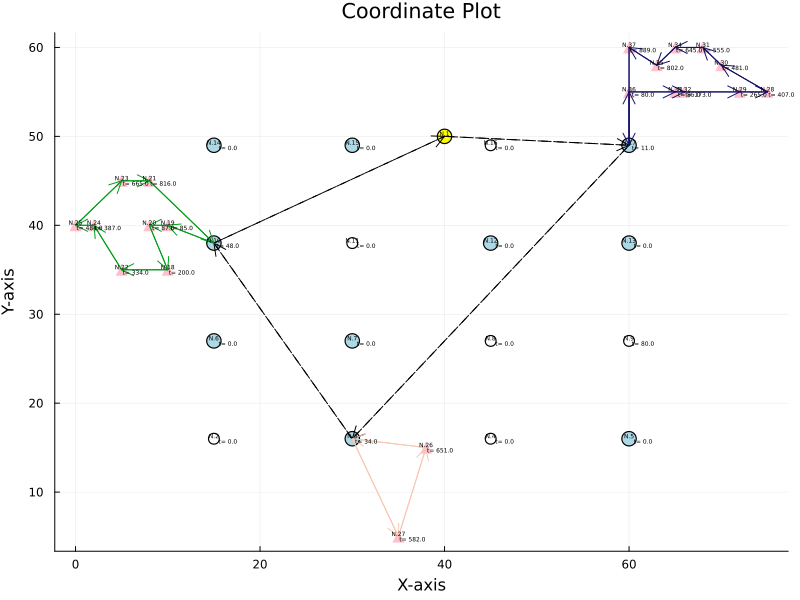

In [10]:
displayMap()

# if termination_status(model) == MOI.OPTIMAL

    time_labels = [string("t= ", round(value(t[i]))) for i in A2]
    node_labels = [string("N.", i) for i in N]
    for i in N
        annotate!(x_coor[i], y_coor[i]+0.3, text(node_labels[i], :center, 4))
        if i in A2
            annotate!(x_coor[i]+1.5, y_coor[i]-0.3, text(time_labels[i-1], :center, 4))
        end
    end     

    # Add FEV arcs between the locations if they are traversed
    for i in A1
        for j in A1         
            if round(value(y[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]],line=:arrow,color = light_green, linealpha=4, lw=4)
            end
            if round(value(x[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]],line=:arrow,color = :black,linestyle=:dash)
            end
        end
    end
    
    # Add SEV arcs between the locations if they are traverse
    for i in P
        colorR = RGBA(rand(),rand(),rand(),1)
        backTracking(z, colorR, i)
    end
# end

plot!()

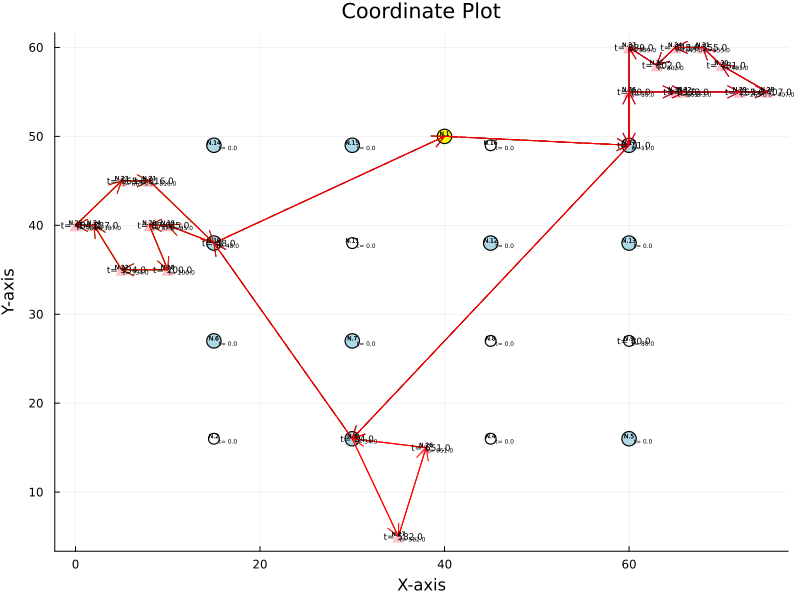

In [11]:
if termination_status(model) == MOI.OPTIMAL
    time_labels = [string("t= ", value(t[i])) for i in A2]
    flow_labels = [string("f(",i,",",j,")= ", value(f[i,j])) for i in A2 for j in A2]
    loan_labels = [string("w= ", value(w[i])) for i in P]
    distances_labels = [string("dist(",i,",",j,")= ", floor(value(distances[i,j]))) for i in N for j in N]
    speed1_labels = [string("travelTime(",i,",",j,")= ", floor(value(TT1[i,j]))) for i in N for j in N]
    speed2_labels = [string("travelTime(",i,",",j,")= ", floor(value(TT2[i,j]))) for i in N for j in N]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)
    
    # color_list = generate_rgb_colors(length(V2))
    node_labels = [string("N.", i) for i in N]
    for i in N
        annotate!(x_coor[i], y_coor[i]+0.3, text(node_labels[i], :center, 4))
    end

    # Add FEV arcs between the locations if they are traversed
    for i in A1
        # if i in P && round(value(w[i])) != 0
        #     annotate!(x_coor[i]+0.5,y_coor[i]-0.2, text(loan_labels[i-1],6 ,:blue))
        # end
        for j in A1         
            if round(value(y[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,arrowhead_size=0.2,color = light_green, label = "", linealpha=4, lw=4)
            end
            if round(value(x[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,arrowhead_size=0.2,color = :red, label = "")
            end
        end
    end
    
    # Add SEV arcs between the locations if they are traverse
    for i in A2
        if value(t[i])!=0 annotate!(x_coor[i]+0.5, y_coor[i], text(time_labels[i-1], :center, 6)) end
        for j in A2
            if round(value(z[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], line=:arrow, color=:red)#, color = color_list[r] )
                # mid_x = (x_coor[i] + x_coor[j]) / 2 
                # mid_y = (y_coor[i] + y_coor[j]) / 2 + 0.2
                # annotate!(mid_x, mid_y, text(SEV_labels[(r-1)*(np+nc)*(np+nc)+(i-2)*(np+nc)+j-1],6 ,:blue))
                # if value(f[i,j]) != 0
                #     mid_x = (x_coor[i] + x_coor[j]) / 2
                #     mid_y = (y_coor[i] + y_coor[j]) / 2 - 0.2
                #     annotate!(mid_x, mid_y, text(flow_labels[(i-2)*(np+nc)+j-1],6 ,:blue))
                # end
            end
        end
    end
end


# for i in A2
#     for j in A2
#         if round(value(z[i,j])) == 1    println("z[",i,",",j,"]=",round(value(z[i,j])))    end
#     end
# end
# 
# for i in A1
#     for j in A1
#         if round(value(x[i,j])) == 1    println("x[",i,",",j,"]=",round(value(x[i,j])))    end
#     end
# end

plot!()